In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

## Fazendo Ajustes Polinomiais para remoção de ruido

In [104]:
path = 'SRAG_time_series/SRAG_TS_weekly.csv'

df = pd.read_csv(path, sep=",", encoding="latin-1")
df["Year_Week"] = pd.to_datetime(df['Year_Week'], format='%Y-%m-%d')
df = df.iloc[1:].reset_index(drop=True)
df

,Year_Week,Number_Cases,week
0,2019-01-07,256.0,2
1,2019-01-14,270.0,3
2,2019-01-21,273.0,4
3,2019-01-28,282.0,5
4,2019-02-04,300.0,6
...,...,...,...
312,2024-12-02,4298.0,49
313,2024-12-09,4284.0,50
314,2024-12-16,4028.0,51
315,2024-12-23,4028.0,52


### Rolling Average
A média contínua é simplesmente a média de uma janela de observações anteriores, em que a janela é uma sequência de valores dos dados da série temporal. A média é calculada para cada janela ordenada. Isso pode ajudar muito a minimizar o ruído nos dados de séries temporais.

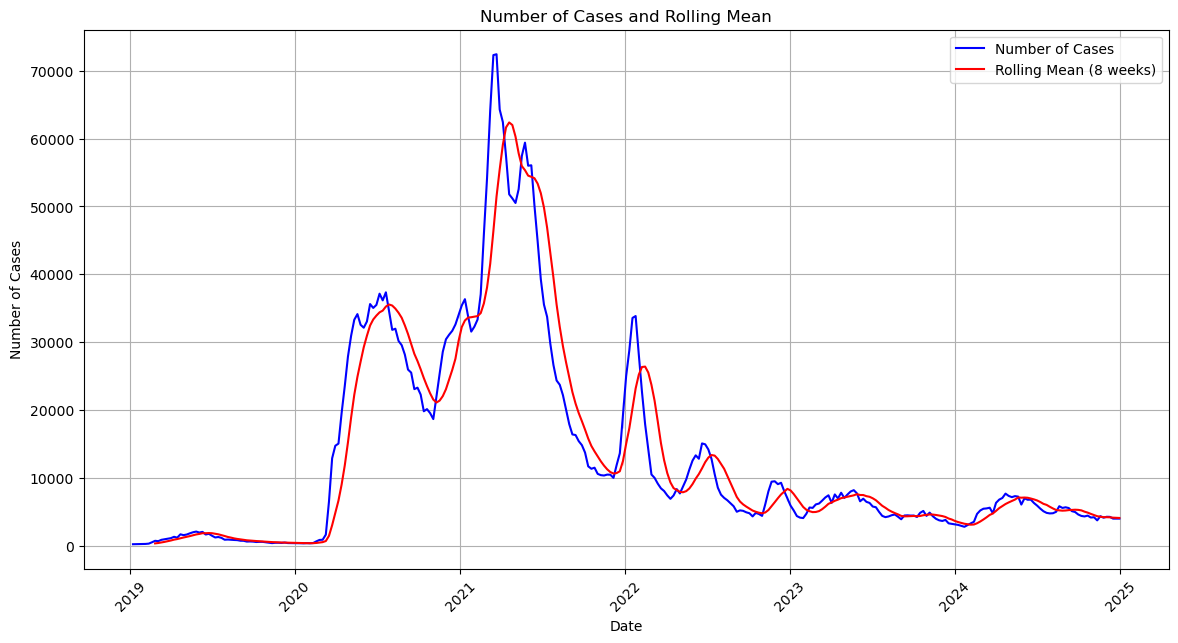

In [163]:
df["rolling_mean"] = df["Number_Cases"].rolling(8).mean()

plt.figure(figsize=(14, 7))

sns.lineplot(data=df, x='Year_Week', y='Number_Cases', label='Number of Cases', color='blue')
sns.lineplot(data=df, x='Year_Week', y='rolling_mean', label='Rolling Mean (8 weeks)', color='red')

# Melhorar o visual
plt.title('Number of Cases and Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Podemos observar algumas limitações desse método:
- Temos uma perda dos dados iniciais
- A suavização possui um atraso na detecção de tendências (Dificil em reconhecer mudanças abruptas)

--

### Transformada de Fourier
Pode ajudar a remover o ruído convertendo os dados da série temporal no domínio da frequência e, a partir daí, podemos filtrar as frequências ruidosas. Em seguida, podemos aplicar a transformada inversa de Fourier para obter a série temporal filtrada.

In [143]:
fft_values = np.fft.fft(df['Number_Cases'])

#Obter as frequências associadas
frequencies = np.fft.fftfreq(len(fft_values))

# eliminar frequências maiores que um limiar
cutoff = 0.1
fft_values_filtered = fft_values.copy()
fft_values_filtered[np.abs(frequencies) > cutoff] = 0

# Aplicar a Transformada Inversa
filtered_signal = np.fft.ifft(fft_values_filtered)

# removendo imaginario
filtered_signal = np.real(filtered_signal)
df["denoised_fourier"] = filtered_signal
df

,Year_Week,Number_Cases,week,rolling_mean,denoised_fourier
0,2019-01-07,256.0,2,NaN,1551.630264
1,2019-01-14,270.0,3,NaN,933.491341
2,2019-01-21,273.0,4,NaN,511.046132
3,2019-01-28,282.0,5,NaN,289.749631
4,2019-02-04,300.0,6,NaN,236.634048
...,...,...,...,...,...
312,2024-12-02,4298.0,49,4231.250,4726.112140
313,2024-12-09,4284.0,50,4223.125,4422.393784
314,2024-12-16,4028.0,51,4167.875,3862.848500
315,2024-12-23,4028.0,52,4148.125,3122.487384


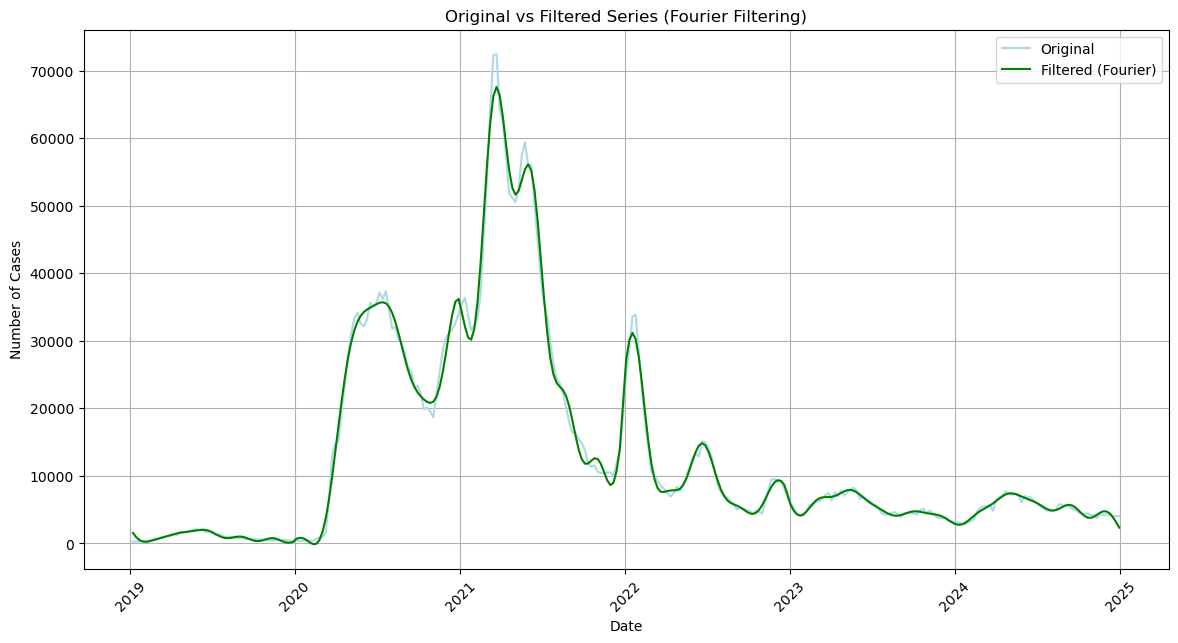

In [149]:
plt.figure(figsize=(14, 7))

sns.lineplot(data=df, x='Year_Week', y='Number_Cases', label='Original', color='lightblue')
sns.lineplot(data=df, x='Year_Week', y='denoised_fourier', label='Filtered (Fourier)', color='green')

plt.title('Original vs Filtered Series (Fourier Filtering)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

--

### Filtro Savitzky-Golay
O filtro de Savitzky-Golay é usado para suavizar séries temporais (remover ruído) sem distorcer muito as tendências — ele faz isso ajustando pequenos polinômios a janelas móveis do seu dado.


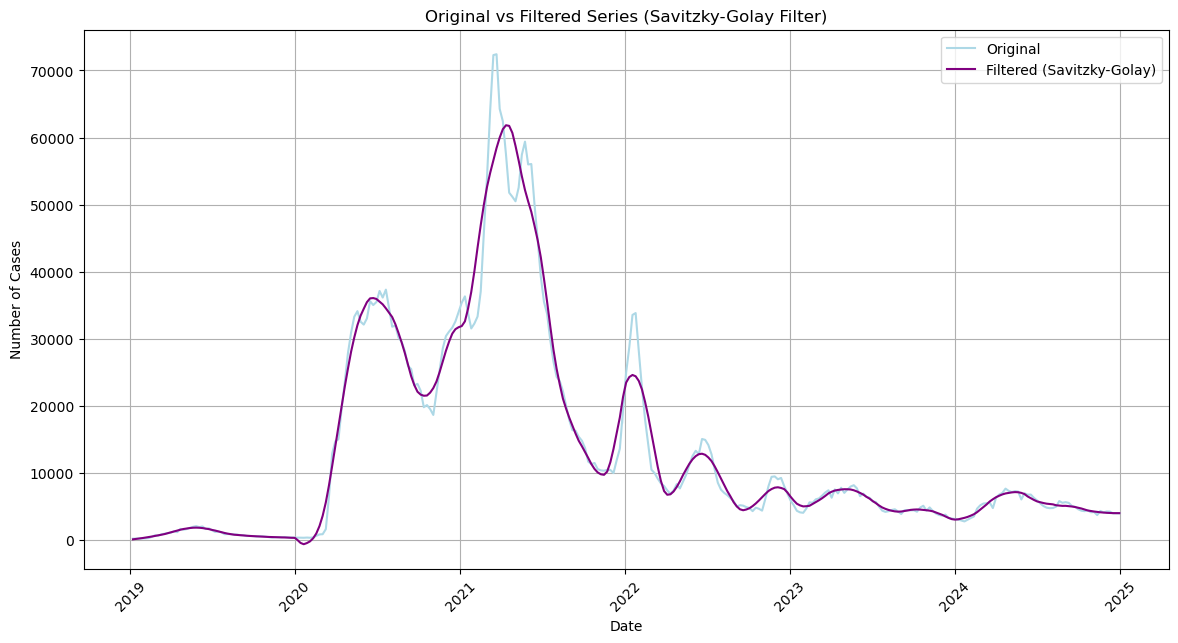

In [172]:
from scipy.signal import savgol_filter

df["denoised_savgol"] = savgol_filter(df["Number_Cases"], window_length=21, polyorder=2)

plt.figure(figsize=(14, 7))

sns.lineplot(data=df, x='Year_Week', y='Number_Cases', label='Original', color='lightblue')
sns.lineplot(data=df, x='Year_Week', y='denoised_savgol', label='Filtered (Savitzky-Golay)', color='purple')

plt.title('Original vs Filtered Series (Savitzky-Golay Filter)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()